In [3]:
# -*- coding: utf-8 -*-
import multiprocessing
import pickle
import time
time.clock= time.time
import sys

from scipy.special import polygamma as pg
from scipy.special import psi as psi

import numpy as np

SMALL_NUMBER = 1e-100

# This is the LDA implementation to use
# K = number of topics
# eta = hyperparameter for topics (i.e. pseudo word counts)
# alpha = initial Dirichlet hyperparameter
# update_alpha = boolean to determine whether or not alpha is updated at each iteration
# word_index is a dictionary storing the position of each feature in numpy arrays
 # word_index is only used in multi-file as it's important that features are always in the same order.
 # In single file it is created internally
class VariationalLDA(object):
    def __init__(self,corpus=None,K = 20,eta=0.1,
        alpha=1,update_alpha=True,word_index=None,normalise = -1,fixed_topics = None,fixed_topics_metadata = None,
        topic_index = None,top_verbose = True):
        self.corpus = corpus
        self.word_index = word_index
        self.normalise = normalise
        #  If the corpus exists, make the word index and the (unused?) word doc matrix
        if not self.corpus == None:
            self.n_docs = len(self.corpus)
            if self.word_index == None:
                self.word_index = self.find_unique_words()
            if top_verbose:
                print ("Object created with {} documents".format(self.n_docs))
            self.n_words = len(self.word_index)
            self.make_doc_index()
            if self.normalise > -1:
                if top_verbose:
                    print ("Normalising intensities")
                #self.normalise_intensities()
        
        self.K = K

        if fixed_topics:
            self.n_fixed_topics = len(fixed_topics)
            self.K += self.n_fixed_topics
        else:
            self.n_fixed_topics = 0


        self.alpha = alpha
        #  If alpha is a single value, make it into a vector
        if type(self.alpha) == int or type(self.alpha) == float:
            self.alpha = self.alpha*np.ones(self.K)
        self.eta = eta # Smoothing parameter for beta
        self.update_alpha = update_alpha
        self.doc_metadata = None
        

        # self.topic_index = topic_index
        # self.topic_metadata = topic_metadata
        self.topic_index = topic_index
        if not self.topic_index:
            self.topic_index = {}
            self.topic_metadata = {}
            topic_pos = 0
            if fixed_topics:
                for topic_name in fixed_topics:
                    self.topic_index[topic_name] = topic_pos
                    #self.topic_metadata[topic_name] = fixed_topics_metadata[topic_name]
                    #self.topic_metadata[topic_name]['type'] = 'fixed'
                    topic_pos += 1
        
            for topic_pos in range(self.n_fixed_topics,self.K):
                topic_name = 'motif_{}'.format(topic_pos)
                #self.topic_index[topic_name] = topic_pos
                #self.topic_metadata[topic_name] = {'name':topic_name,'type':'learnt'}

        if fixed_topics:
            self._add_exact_fixed_topics(fixed_topics)
            

    def _add_exact_fixed_topics(self,fixed_topics):
        # first add any missing words
        #word_pos = max(self.word_index.values())+1

        #for topic,spectrum in fixed_topics.items():
         #   for word in spectrum:
          #      if not word in self.word_index:
           #         self.word_index[word] = word_pos
            #        word_pos += 1
        #self.n_words = len(self.word_index)

        # Now make the fixed rows of beta
        self.beta_matrix = np.zeros((self.K,self.n_words),np.float64) + SMALL_NUMBER
        #self.beta_matrix[0:50,:] = fixed_topics
        for topic_pos,spectrum in fixed_topics.items():
                for word_pos,val in spectrum.items():
                    self.beta_matrix[topic_pos,word_pos] = val
                self.beta_matrix[topic_pos,:] /= self.beta_matrix[topic_pos,:].sum()


    def create_word_index (self,df):
        word_index = {}
        pos = 0
        for word in list(df.T.columns):
            word_index[word] = pos
            pos += 1
        return word_index
   
    def create_doc_index (self,df):
        self.doc_index = {}
        doc_pos = 0
        for doc in list(df.T.index):
            self.doc_index[doc] = doc_pos
            doc_pos += 1
                
    def load_data_sc(self,df):
        print ("Edited")
        self.n_docs = df.T.shape[0]
        self.word_index = self.create_word_index(df)
        self.create_doc_index(df)
        self.n_words = df.T.shape[1]
        self.corpus = df.T.to_dict(orient="index")
        for doc in self.corpus.keys(): 
            self.corpus[doc] = {key:val for key, val in self.corpus[doc].items() if val != 0}
        
 
        
        
   
    # Run the VB inference. Verbose = True means it gives output each iteration
    # initialise = True initialises (i.e. restarts the algorithm)
    # This means we can run the algorithm from where it got to.
    # First time its run, initialise has to be True
    def run_vb(self,n_its = 1,verbose=True,initialise=True):
        if initialise:
            if verbose:
                print ("Initialising")
            self.init_vb()
        if verbose:
            print ("Starting iterations")
        for it in range(n_its):
            start_time = time.clock()
            diff = self.vb_step()
            end_time = time.clock()
            self.its_performed += 1
            estimated_finish = ((end_time - start_time)*(n_its - it)/60.0)
            if verbose:
                print ("Iteration {} (change = {}) ({} seconds, I think I'll finish in {} minutes). Alpha: ({},{})".format(it,diff,end_time - start_time,estimated_finish,self.alpha.min(),self.alpha.max()))

    # D a VB step
    def vb_step(self):
        # Run an e-step
        temp_beta = self.e_step()
        temp_beta += self.eta
        # Do the normalisation in the m step
        if self.n_fixed_topics > 0:
            temp_beta[:self.n_fixed_topics,:] = self.beta_matrix[:self.n_fixed_topics,:]
        temp_beta /= temp_beta.sum(axis=1)[:,None]
        # Compute how much the word probabilities have changed
        total_difference = (np.abs(temp_beta - self.beta_matrix)).sum()
        self.beta_matrix = temp_beta
        # If we're updating alpha, run the alpha update
        if self.update_alpha:
            self.alpha = self.alpha_nr(init_alpha = self.alpha.copy())
        return total_difference
        # self.m_step()

    # Newton-Raphson procedure for updating alpha
    def alpha_nr(self,maxit=20,init_alpha=[]):
        old_alpha = self.alpha.copy()
        try:
            M,K = self.gamma_matrix.shape
            if not len(init_alpha) > 0:
                init_alpha = self.gamma_matrix.mean(axis=0)/K
            alpha = init_alpha.copy()
            alphap = init_alpha.copy()
            g_term = (psi(self.gamma_matrix) - psi(self.gamma_matrix.sum(axis=1))[:,None]).sum(axis=0)
            for it in range(maxit):
                grad = M *(psi(alpha.sum()) - psi(alpha)) + g_term
                H = -M*np.diag(pg(1,alpha)) + M*pg(1,alpha.sum())


                # playing here....
                z = M*pg(1,alpha.sum())
                h = -M*pg(1,alpha)
                c = ((grad/h).sum())/((1.0/z) + (1.0/h).sum())
                alpha_change = (grad - c)/h

                n_bad = (alpha_change > alpha).sum()
                while n_bad > 0:
                    alpha_change/=2.0
                    n_bad = (alpha_change > alpha).sum()

                
                alpha_new = alpha - alpha_change

                pos = np.where(alpha_new <= SMALL_NUMBER)[0]
                alpha_new[pos] = SMALL_NUMBER

                # if (alpha_new < 0).sum() > 0:
                #   init_alpha /= 10.0
                #   return self.alpha_nr(maxit=maxit,init_alpha = init_alpha)

                diff = np.sum(np.abs(alpha-alpha_new))
                alpha = alpha_new
                if diff < 1e-6 and it > 1:
                    return alpha
        except:
            alpha = old_alpha
        return alpha

    # TODO: tidy up and comment this function
    def e_step(self):
        temp_beta = np.zeros((self.K,self.n_words))
        for doc in self.corpus:
            d = self.doc_index[doc]
            temp_gamma = np.zeros(self.K) + self.alpha
            for word in self.corpus[doc]:
                w = self.word_index[word]
                log_phi_matrix = np.log(self.beta_matrix[:,w]) + psi(self.gamma_matrix[d,:]).T
                # self.phi_matrix[doc][word] = self.beta_matrix[:,w]*np.exp(psi(self.gamma_matrix[d,:])).T
                # for k in range(self.K):
                #   self.phi_matrix[doc][word][k] = self.beta_matrix[k,w]*np.exp(scipy.special.psi(self.gamma_matrix[d,k]))
                log_phi_matrix = np.exp(log_phi_matrix - log_phi_matrix.max())
                self.phi_matrix[doc][word] = log_phi_matrix/log_phi_matrix.sum()
                # self.phi_matrix[doc][word] /= self.phi_matrix[doc][word].sum()
                temp_gamma += self.phi_matrix[doc][word]*self.corpus[doc][word]
                temp_beta[:,w] += self.phi_matrix[doc][word] * self.corpus[doc][word]
            # self.phi_matrix[d,:,:] = (self.beta_matrix * self.word_matrix[d,:][None,:] * (np.exp(scipy.special.psi(self.gamma_matrix[d,:]))[:,None])).T
            # self.phi_matrix[d,:,:] /= self.phi_matrix[d,:,:].sum(axis=1)[:,None]
            # self.gamma_matrix[d,:] = self.alpha + self.phi_matrix[d,:,:].sum(axis=0)
            self.gamma_matrix[d,:] = temp_gamma
            pos = np.where(self.gamma_matrix[d,:]<SMALL_NUMBER)[0]
            self.gamma_matrix[d,pos] = SMALL_NUMBER
        return temp_beta

    # Function to find the unique words in the corpus and assign them to indices
    def find_unique_words(self):
        word_index = {}
        pos = 0
        for doc in self.corpus:
            for word in self.corpus[doc]:
                if not word in word_index:
                    word_index[word] = pos
                    pos += 1
        print ("Found {} unique words".format(len(word_index)))
        return word_index

    # Pretty sure this matrix is never used
    def make_doc_index(self):
        self.doc_index = {}
        doc_pos = 0
        for doc in self.corpus:
            self.doc_index[doc] = doc_pos
            doc_pos += 1

    # Initialise the VB algorithm
    # TODO: tidy this up
    def init_vb(self):
        # self.gamma_matrix = np.zeros((self.n_docs,self.K),np.float) + 1.0
        # self.phi_matrix = np.zeros((self.n_docs,self.n_words,self.K))
        self.its_performed = 0
        self.phi_matrix = {}
        self.gamma_matrix = np.zeros((self.n_docs,self.K))
        for doc in self.corpus:
            self.phi_matrix[doc] = {}
            for word in self.corpus[doc]:
                self.phi_matrix[doc][word] = np.zeros(self.K)
            d = self.doc_index[doc]
            doc_total = 0.0
            for word in self.corpus[doc]:
                doc_total += self.corpus[doc][word]
            self.gamma_matrix[d,:] = self.alpha + 1.0*doc_total/self.K
        # # Normalise this to sum to 1
        # self.phi_matrix /= self.phi_matrix.sum(axis=2)[:,:,None]

        # Initialise the betas
        if self.n_fixed_topics == 0:
            # self.beta_matrix = np.random.rand(self.K,self.n_words)
            self.beta_matrix = np.zeros((self.K,self.n_words),np.double)
            for k in range(self.K):
                self.beta_matrix[k,:] = np.random.dirichlet(self.eta*np.ones(self.n_words)) 
        else:
            print ("Here")
            for k in range(self.n_fixed_topics,self.K):
                self.beta_matrix[k,:] = np.random.dirichlet(self.eta*np.ones(self.n_words))
        self.beta_matrix /= self.beta_matrix.sum(axis=1)[:,None]

    # Function to return a dictionary with keys equal to documents and values equal to the probability
    # of the requested document (used for visusaling in DESI imaging)
    def get_topic_as_doc_dict(self,topic_id,thresh = 0.001,normalise=False):
        top = {}
        mat = self.gamma_matrix
        if normalise:
            mat = self.get_expect_theta()

        for doc in self.doc_index:
            pos = self.doc_index[doc]
            if mat[pos,topic_id] >= thresh:
                top[doc] = mat[pos,topic_id]
        return top

    # Return a topic as a dictionary over words
    def get_topic_as_dict(self,topic_id):
        top = {}
        for word in self.word_index:
            top[word] = self.beta_matrix[topic_id,self.word_index[word]]
        return top

    # Return the topic probabilities for all documents 
    # Note that self.doc_index maps the document names to their
    # position in this matrix
    def get_expect_theta(self):
        e_theta = self.gamma_matrix.copy()
        e_theta /= e_theta.sum(axis=1)[:,None]
        return e_theta

    def get_beta(self):
        return self.beta_matrix.copy()

    def make_dictionary(self,metadata=None,min_prob_to_keep_beta = 1e-3,
        min_prob_to_keep_phi = 1e-2,min_prob_to_keep_theta = 1e-2,
        filename = None,features = None,compute_overlaps = True):

        if metadata == None:
            if self.doc_metadata == None:
                metadata = {}
                for doc in self.corpus:
                    metadata[doc] = {'name': doc,'parentmass': float(doc.split('_')[0])}
            else:
                metadata = self.doc_metadata

        lda_dict = {}
        lda_dict['corpus'] = self.corpus
        lda_dict['word_index'] = self.word_index
        lda_dict['doc_index'] = self.doc_index
        lda_dict['K'] = self.K
        lda_dict['alpha'] = list(self.alpha)
        lda_dict['beta'] = {}
        lda_dict['doc_metadata'] = metadata
        lda_dict['topic_index'] = self.topic_index
        lda_dict['topic_metadata'] = self.topic_metadata
        
        pure_gamma = []
        for gamma in self.gamma_matrix:
            pure_gamma.append(list(gamma))

        lda_dict['gamma'] = gamma

        if features:
            lda_dict['features'] = features

        # Create the inverse indexes
        wi = []
        for i in self.word_index:
            wi.append((i,self.word_index[i]))
        wi = sorted(wi,key = lambda x: x[1])

        di = []
        for i in self.doc_index:
            di.append((i,self.doc_index[i]))
        di = sorted(di,key=lambda x: x[1])

        ri,i = zip(*wi)
        ri = list(ri)
        di,i = zip(*di)
        di = list(di)

        # make a reverse index for topics
        tp = [(topic,self.topic_index[topic]) for topic in self.topic_index]
        tp = sorted(tp,key = lambda x: x[1])
        reverse,_ = zip(*tp)

        for k in range(self.K):
            pos = np.where(self.beta_matrix[k,:]>min_prob_to_keep_beta)[0]
            motif_name = reverse[k]
            # motif_name = 'motif_{}'.format(k)
            lda_dict['beta'][motif_name] = {}
            for p in pos:
                word_name = ri[p]
                lda_dict['beta'][motif_name][word_name] = self.beta_matrix[k,p]

        eth = self.get_expect_theta()
        lda_dict['theta'] = {}
        for i,t in enumerate(eth):
            doc = di[i]
            lda_dict['theta'][doc] = {}
            pos = np.where(t > min_prob_to_keep_theta)[0]
            for p in pos:
                motif_name = reverse[p]
                # motif_name = 'motif_{}'.format(p)
                lda_dict['theta'][doc][motif_name] = t[p]

        lda_dict['phi'] = {}
        ndocs = 0
        for doc in self.corpus:
            ndocs += 1
            lda_dict['phi'][doc] = {}
            for word in self.corpus[doc]:
                lda_dict['phi'][doc][word] = {}
                pos = np.where(self.phi_matrix[doc][word] >= min_prob_to_keep_phi)[0]
                for p in pos:
                    motif_name = reverse[p]
                    lda_dict['phi'][doc][word][motif_name] = self.phi_matrix[doc][word][p]
            if ndocs % 500 == 0:
                print ("Done {}".format(ndocs))

        if compute_overlaps:
            os = compute_overlap_scores(lda_dict)
            lda_dict['overlap_scores'] = os

        if not filename == None:
            with open(filename,'w') as f:
                pickle.dump(lda_dict,f)

        return lda_dict



In [4]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib.patches as mpatches

from scipy import spatial
from scipy.stats import binom
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from scipy.spatial.distance import cosine
from itertools import combinations

stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)


#returns a re-normalised delta: all new topics set to 0; old ones normalised
def deltaCell(cellID,documentTopicMatrix,oldTopics,allTopics):
    theta = documentTopicMatrix.loc[cellID]
    delta = np.zeros(allTopics)
    totalSum = sum(theta[0:oldTopics])
    delta[0:oldTopics] = theta[0:oldTopics]/totalSum
    return delta 


def calculateProbs(cellID, geneName,totalTopics,oldTopics,doubletsMatrix,topicWordsMatrix,documentTopicMatrix):
    total = 0
    total2 = 0
    n = doubletsMatrix.T[cellID].sum()
    x = doubletsMatrix.T[cellID][geneName]
    delta = deltaCell(cellID,documentTopicMatrix,oldTopics, totalTopics)
    p = topicWordsMatrix[geneName][0:totalTopics].values
    prob = (1-binom.cdf(x, n, p))+binom.pmf(x, n, p)
    total = sum(documentTopicMatrix.T[cellID].values*prob)
    total2 = sum(delta*prob)
    return (total, total2)


def expectedActualPlot(geneName,totalTopics,oldTopics,cellMatrix,topicWordsMatrix,documentTopicMatrix,dpi=120):
    x = []
    y = []
    for i in cellMatrix.index:
        t,t1= calculateProbs(i,geneName,totalTopics,oldTopics,cellMatrix,topicWordsMatrix,documentTopicMatrix)
        x.append(t)
        y.append(t1)
    plt.scatter(x,y)
    plt.title(geneName,fontsize=20)
    plt.xlabel("Probability given all topics",fontsize=15)
    plt.ylabel("Probability given initial topics",fontsize=15)
    plt.tight_layout()
    plt.savefig(geneName+"_prob_plot.png",dpi=dpi)
    
    

def lrtest(llmin, llmax):
    lr = -2 * (np.log(llmin)-np.log(llmax))
    p = stats.chisqprob(lr,30)
    return lr, p


#gene ranking per topic
def ranking_genes (oldTopicNum, newTopicsNum,scLDAObject,geneNames):
    interesting_genes = pd.DataFrame()
    for k in range(oldTopicNum,newTopicsNum):
        genesNeed = []
        in_newT = []
        percentages = []
        for geneName in geneNames:
            in_new = 0
            in_old = 0
            for key in scLDAObject.phi_matrix.keys():
                if geneName in scLDAObject.phi_matrix[key].keys():
                    if scLDAObject.phi_matrix[key][geneName].argmax()==k:
                        in_new+=1
                    else:
                        in_old+=1
            if in_new>0:
                genesNeed.append(geneName)
                in_newT.append(in_new)
                percentages.append(in_new/(in_new+in_old))
        ranked_genes = pd.DataFrame([genesNeed,in_newT,percentages,np.full((len(genesNeed),1),k)])
        ranked_genes = ranked_genes.T
        ranked_genes = ranked_genes.sort_values([2,1],ascending=False)
        interesting_genes = pd.concat([interesting_genes,ranked_genes])
    
    return interesting_genes


def ranking_genes_realData (oldTopicNum, newTopicsNum,scLDAObject,geneNames):
    interesting_genes = pd.DataFrame()
    for k in range(oldTopicNum,newTopicsNum):
        genesNeed = []
        in_newT = []
        percentages = []
        for geneName in geneNames:
            in_new = 0
            in_old = 0
            for key in scLDAObject.phi_matrix.keys():
                if geneName in scLDAObject.phi_matrix[key].keys():
                    if scLDAObject.phi_matrix[key][geneName].argmax()==k:
                        in_new+=1
                    else:
                        in_old+=1
            if in_new>0:
                genesNeed.append(geneName)
                in_newT.append(in_new)
                percentages.append(in_new/(in_new+in_old))
        ranked_genes = pd.DataFrame([genesNeed,in_newT,percentages,np.full((len(genesNeed),1),k)])
        ranked_genes = ranked_genes.T
        ranked_genes = ranked_genes.sort_values([2,1],ascending=False)
        interesting_genes = interesting_genes.append(ranked_genes[ranked_genes[1]>10])
        
    return interesting_genes



def getROCarrays(oldT,newT,interesting_genes,ground_truth,cutOffList):
    p = []
    n = []
    for i in cutOffList:
        pos,neg = rocCurveValues(oldT,newT,interesting_genes, ground_truth,i)
        p.append(len(pos))
        n.append(len(list(set(neg))))
    return p,n
    
    
def rocCurveValues(oldT, newT,interesting_genes,ground_truth,topGenesCutOff):
    positive = []
    negative = []
    for i in range(oldT,newT):
        for k in interesting_genes[interesting_genes[3]==i].sort_values([1],ascending=False)[0:topGenesCutOff][0].values:
            if k in ground_truth and k not in positive: 
                positive.append(k)
            if k not in ground_truth:
                negative.append(k)
    return positive, negative



def computeCosine (LDAModel,topic1, topic2):
    t1 = LDAModel.beta_matrix[topic1]
    t2 = LDAModel.beta_matrix[topic2]
    return 1-cosine(t1,t2)


def averageDistance(LDAModel):
    totalDistance = 0
    nT = LDAModel.beta_matrix.shape[0]
    numTopics = [i for i in range(0,nT)]
    combs = combinations(numTopics,2)
    for i in list(combs):
        totalDistance+=computeCosine(LDAModel,i[0],i[1])
    
    totalDistance = totalDistance/(nT*(nT-1)/2)
    return totalDistance

    
    


    

In [7]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sb
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from matplotlib.transforms import Bbox
#sys.path.append('../code/')
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
#from ldaSingleCell import VariationalLDA
#from utilsFuncs import *
import re



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
my_obj = pd.read_csv('BCan.csv', header=0, index_col=0)

In [9]:
Meta= pd.read_csv('BCan_meta.csv', header=0, index_col=0)

In [11]:
my_obj.shape

(26914, 9878)

In [12]:
Meta.shape

(9878, 14)

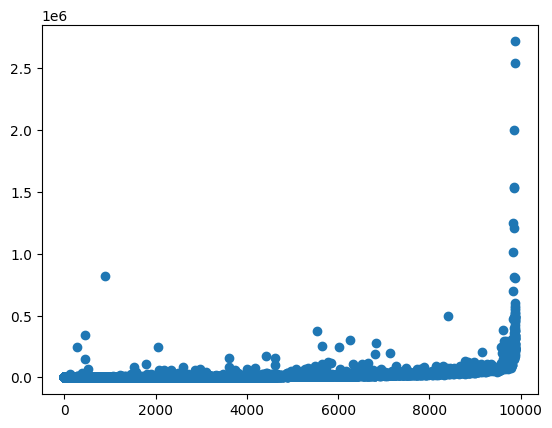

In [13]:
CountsAll= my_obj
plt.plot(CountsAll.astype(bool).sum(axis=1),CountsAll.sum(axis=1),'o')

In [14]:
countsAll= CountsAll
countsAll[(countsAll.astype(bool).sum(axis=1)>100) & (countsAll.astype(bool).sum(axis=1)<10000)]

,AAACCCACATGAAGCG-1,AAACCCACATGACTCA-1,AAACCCAGTTAATCGC-1,AAACGAACAAATCCCA-1,AAACGAAGTAGCTGAG-1,AAACGAAGTGAGGATC-1,AAACGCTCAGTAGAGC-1,AAACGCTTCTGGAAGG-1,AAAGAACGTGGCAACA-1,AAAGGATCACCCTGAG-1,...,TTTCATGGTTGCCTAA-1,TTTCCTCAGAAAGTCT-1,TTTCGATGTCATTGCA-1,TTTGACTAGTCAACAA-1,TTTGATCAGACTTAAG-1,TTTGATCCAATCCTTT-1,TTTGGAGAGGCCTAGA-1,TTTGGAGAGTAAAGCT-1,TTTGGTTTCCCATGGG-1,TTTGTTGTCCGTCAAA-1
AL669831.5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
LINC00115,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FAM41C,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SAMD11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NOC2L,2,0,0,0,0,0,0,0,0,0,...,0,2,6,1,3,2,0,2,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC011043.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AL592183.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AL354822.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AC004556.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
countsFiltered = countsAll[(countsAll.astype(bool).sum(axis=1)>100) & (countsAll.astype(bool).sum(axis=1)<10000)]


In [16]:
countsFiltered

,AAACCCACATGAAGCG-1,AAACCCACATGACTCA-1,AAACCCAGTTAATCGC-1,AAACGAACAAATCCCA-1,AAACGAAGTAGCTGAG-1,AAACGAAGTGAGGATC-1,AAACGCTCAGTAGAGC-1,AAACGCTTCTGGAAGG-1,AAAGAACGTGGCAACA-1,AAAGGATCACCCTGAG-1,...,TTTCATGGTTGCCTAA-1,TTTCCTCAGAAAGTCT-1,TTTCGATGTCATTGCA-1,TTTGACTAGTCAACAA-1,TTTGATCAGACTTAAG-1,TTTGATCCAATCCTTT-1,TTTGGAGAGGCCTAGA-1,TTTGGAGAGTAAAGCT-1,TTTGGTTTCCCATGGG-1,TTTGTTGTCCGTCAAA-1
AL669831.5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
LINC00115,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FAM41C,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SAMD11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NOC2L,2,0,0,0,0,0,0,0,0,0,...,0,2,6,1,3,2,0,2,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC011043.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AL592183.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AL354822.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AC004556.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
p = re.compile("RPS|RPL|RP")
list(filter(p.match,countsFiltered.index.values))

['RPL22',
 'RPL11',
 'RPS6KA1',
 'RPA2',
 'RPS8',
 'RPF1',
 'RPAP2',
 'RPL5',
 'RPRD2',
 'RPS27',
 'RPS6KC1',
 'RPS7',
 'RPS27A',
 'RPIA',
 'RPL31',
 'RPRM',
 'RPE',
 'RPL37A',
 'RPUSD3',
 'RPL32',
 'RPL15',
 'RPSA',
 'RPL14',
 'RPL29',
 'RPP14',
 'RPL24',
 'RPN1',
 'RPL22L1',
 'RPL39L',
 'RPL35A',
 'RPL9',
 'RPL34',
 'RPS3A',
 'RPL37',
 'RPS23',
 'RPS14',
 'RPL26L1',
 'RPP40',
 'RPP21',
 'RPS18',
 'RPS10',
 'RPL10A',
 'RPL7L1',
 'RPF2',
 'RPS12',
 'RPS6KA2',
 'RPA3',
 'RP9',
 'RPS6KA3',
 'RPGR',
 'RP2',
 'RPS4X',
 'RPS6KA6',
 'RPA4',
 'RPL36A',
 'RPL39',
 'RPL10',
 'RP1',
 'RPS20',
 'RPL7',
 'RPL30',
 'RPL8',
 'RPS6',
 'RPP25L',
 'RPL35',
 'RPL12',
 'RPL7A',
 'RPLP2',
 'RPL27A',
 'RPS13',
 'RPS6KA4',
 'RPS6KB2',
 'RPS3',
 'RPS25',
 'RPUSD4',
 'RPP38',
 'RPS24',
 'RPP30',
 'RPAP3',
 'RPS26',
 'RPL41',
 'RPL6',
 'RPLP0',
 'RPL21',
 'RPS29',
 'RPL36AL',
 'RPS6KL1',
 'RPS6KA5',
 'RPUSD2',
 'RPAP1',
 'RPS27L',
 'RPL4',
 'RPLP1',
 'RPP25',
 'RPS17',
 'RPUSD1',
 'RPS2',
 'RPS15A',
 'RPGRIP1L

In [18]:
countsFiltered = countsFiltered.drop(list(filter(p.match,countsFiltered.index.values)),axis=0)

In [19]:
countsFiltered

,AAACCCACATGAAGCG-1,AAACCCACATGACTCA-1,AAACCCAGTTAATCGC-1,AAACGAACAAATCCCA-1,AAACGAAGTAGCTGAG-1,AAACGAAGTGAGGATC-1,AAACGCTCAGTAGAGC-1,AAACGCTTCTGGAAGG-1,AAAGAACGTGGCAACA-1,AAAGGATCACCCTGAG-1,...,TTTCATGGTTGCCTAA-1,TTTCCTCAGAAAGTCT-1,TTTCGATGTCATTGCA-1,TTTGACTAGTCAACAA-1,TTTGATCAGACTTAAG-1,TTTGATCCAATCCTTT-1,TTTGGAGAGGCCTAGA-1,TTTGGAGAGTAAAGCT-1,TTTGGTTTCCCATGGG-1,TTTGTTGTCCGTCAAA-1
AL669831.5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
LINC00115,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FAM41C,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SAMD11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NOC2L,2,0,0,0,0,0,0,0,0,0,...,0,2,6,1,3,2,0,2,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC011043.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AL592183.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AL354822.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AC004556.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
referenceCells= Meta[Meta['neigb_class']=='Singlet']

In [21]:
Meta.columns

Index(['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt',
       'RNA_snn_res.0.3', 'seurat_clusters', 'ScType_cell', 'celltype_main',
       'celltype_fine', 'refined_celltype', 'new.clusters', 'final_clusters',
       'neigb_class', 'neigb_type'],
      dtype='object')

In [22]:
referenceCells.head

<bound method NDFrame.head of                        orig.ident  nCount_RNA  nFeature_RNA  percent.mt   
AAACCCACATGAAGCG-1  SeuratProject        7928          2213    6.180626  \
AAACCCACATGACTCA-1  SeuratProject        7066          1653    8.123408   
AAACCCAGTTAATCGC-1  SeuratProject        5808          1184    6.267218   
AAACGAACAAATCCCA-1  SeuratProject        8638          2363    5.267423   
AAACGAAGTAGCTGAG-1  SeuratProject        7958          2543    5.001257   
...                           ...         ...           ...         ...   
TTTGATCCAATCCTTT-1  SeuratProject       13466          3311    7.738007   
TTTGGAGAGGCCTAGA-1  SeuratProject       10798          2824    9.103538   
TTTGGAGAGTAAAGCT-1  SeuratProject        7568          2862    6.633192   
TTTGGTTTCCCATGGG-1  SeuratProject       14810          3079    1.539500   
TTTGTTGTCCGTCAAA-1  SeuratProject       13284          3209    9.552846   

                    RNA_snn_res.0.3  seurat_clusters   
AAACCCACATGAA

In [23]:
#referenceCells.index = [i.replace("-",".") for i in referenceCells.index]

In [24]:
countsFiltered.T

,AL669831.5,LINC00115,FAM41C,SAMD11,NOC2L,KLHL17,PLEKHN1,AL645608.8,HES4,ISG15,...,MT-ND4,MT-ND5,MT-ND6,MT-CYB,AC136616.1,AC011043.1,AL592183.1,AL354822.1,AC004556.1,AC240274.1
AAACCCACATGAAGCG-1,0,0,0,0,2,0,0,0,1,9,...,51,14,0,47,0,0,0,0,0,0
AAACCCACATGACTCA-1,0,0,0,0,0,0,0,0,0,5,...,69,31,0,62,0,0,0,0,0,0
AAACCCAGTTAATCGC-1,0,0,0,0,0,0,0,0,0,0,...,46,7,1,53,0,0,0,0,0,0
AAACGAACAAATCCCA-1,0,0,0,0,0,0,0,0,7,70,...,40,15,0,44,0,0,0,0,0,0
AAACGAAGTAGCTGAG-1,0,0,0,0,0,0,0,0,0,22,...,39,12,0,38,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGATCCAATCCTTT-1,0,0,0,0,2,0,0,0,0,7,...,133,38,0,113,0,0,0,0,0,0
TTTGGAGAGGCCTAGA-1,0,0,0,0,0,0,0,0,0,0,...,106,15,3,166,0,0,0,0,0,0
TTTGGAGAGTAAAGCT-1,0,0,0,0,2,0,0,0,2,1,...,40,9,1,14,0,0,0,0,0,0
TTTGGTTTCCCATGGG-1,0,0,0,0,0,0,0,0,1,3,...,32,14,0,9,0,0,0,0,0,0


In [25]:
referenceCounts= countsFiltered[referenceCells.index]

In [26]:
referenceCounts

,AAACCCACATGAAGCG-1,AAACCCACATGACTCA-1,AAACCCAGTTAATCGC-1,AAACGAACAAATCCCA-1,AAACGAAGTAGCTGAG-1,AAACGAAGTGAGGATC-1,AAACGCTCAGTAGAGC-1,AAACGCTTCTGGAAGG-1,AAAGAACGTGGCAACA-1,AAAGGATCACCCTGAG-1,...,TTTCATGGTTGCCTAA-1,TTTCCTCAGAAAGTCT-1,TTTCGATGTCATTGCA-1,TTTGACTAGTCAACAA-1,TTTGATCAGACTTAAG-1,TTTGATCCAATCCTTT-1,TTTGGAGAGGCCTAGA-1,TTTGGAGAGTAAAGCT-1,TTTGGTTTCCCATGGG-1,TTTGTTGTCCGTCAAA-1
AL669831.5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
LINC00115,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FAM41C,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SAMD11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NOC2L,2,0,0,0,0,0,0,0,0,0,...,0,2,6,1,3,2,0,2,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC011043.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AL592183.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AL354822.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AC004556.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
doubletCells= Meta[Meta['neigb_class']=='Doublet']

In [28]:
doubletCells.head

<bound method NDFrame.head of                        orig.ident  nCount_RNA  nFeature_RNA  percent.mt   
AGTACTGCAAAGTGTA-1  SeuratProject       21054          3767    9.532630  \
CAACAGTCAAACAGGC-1  SeuratProject       18888          3520    7.242694   
CTCCCAATCGGCTCTT-1  SeuratProject       29044          5244    7.622917   
CTTCTCTCAACATACC-1  SeuratProject       23697          5131    0.675191   
GGTTAACCAGTTTCAG-1  SeuratProject       18565          4421    4.863991   
...                           ...         ...           ...         ...   
TGTGATGTCTGCTTTA-1  SeuratProject       18917          4081    4.366443   
TGTTCCGTCTGAGAAA-1  SeuratProject       22166          4605    5.458811   
GGCTTGGTCTTCACAT-1  SeuratProject       33708          4827    4.711048   
TCGAAGTTCGTGAGAG-1  SeuratProject       17431          4258    6.563020   
TTACGCCCAATGCAGG-1  SeuratProject       28500          4715    3.235088   

                    RNA_snn_res.0.3  seurat_clusters   ScType_cell   

In [29]:
doubletsCounts = countsFiltered[doubletCells.index]
doubletsCounts.shape

(14458, 228)

In [30]:
#setting up LDA
singleCellLDA = VariationalLDA(K = 10,alpha = 1,eta=0.005,update_alpha=True)
singleCellLDA.load_data_sc(referenceCounts)
singleCellLDA.run_vb(n_its = 50,initialise=True)

Edited
Initialising
Starting iterations


/tmp/ipykernel_244537/2249788462.py:224: RuntimeWarning: divide by zero encountered in log
  log_phi_matrix = np.log(self.beta_matrix[:,w]) + psi(self.gamma_matrix[d,:]).T


Iteration 0 (change = 18.14853742806758) (178.86983346939087 seconds, I think I'll finish in 149.05819455782571 minutes). Alpha: (9.957465212833652,18.96744465132907)
Iteration 1 (change = 0.03213362980578205) (175.16627955436707 seconds, I think I'll finish in 143.05246163606643 minutes). Alpha: (9.726220760539833,18.51698012817098)
Iteration 2 (change = 0.028753584175749726) (176.43841433525085 seconds, I think I'll finish in 141.1507314682007 minutes). Alpha: (9.65790127458345,18.375859974033)
Iteration 3 (change = 0.02924602289452937) (177.2437834739685 seconds, I think I'll finish in 138.84096372127533 minutes). Alpha: (9.625873288782971,18.305326278793785)
Iteration 4 (change = 0.02979008440762331) (174.03267097473145 seconds, I think I'll finish in 133.42504774729412 minutes). Alpha: (9.594765799827968,18.2363254435688)
Iteration 5 (change = 0.030431405412270733) (173.26657795906067 seconds, I think I'll finish in 129.9499334692955 minutes). Alpha: (9.553118887854781,18.14578630

In [ ]:
topic_dict = pd.DataFrame(singleCellLDA.beta_matrix,index=None).to_dict(orient='index')

In [ ]:
scLDA = VariationalLDA(corpus=singleCellLDA.corpus,K=20,
                       word_index=singleCellLDA.word_index,
                       alpha=1,eta=0.0005,update_alpha=True, fixed_topics=topic_dict)

Object created with 9650 documents


In [ ]:
wordTopic = pd.DataFrame(singleCellLDA.beta_matrix, columns=referenceCounts.index)

In [ ]:
scLDA.load_data_sc(doubletsCounts)

Edited


In [ ]:
scLDA.run_vb(n_its=100,initialise=True)

Initialising
Here
Starting iterations


/tmp/ipykernel_227794/2249788462.py:224: RuntimeWarning: divide by zero encountered in log
  log_phi_matrix = np.log(self.beta_matrix[:,w]) + psi(self.gamma_matrix[d,:]).T


Iteration 0 (change = 27.907595951635145) (6.452226638793945 seconds, I think I'll finish in 10.753711064656576 minutes). Alpha: (1.030251373842439,76.19077933710481)
Iteration 1 (change = 5.31598741483044) (5.8626978397369385 seconds, I think I'll finish in 9.673451435565948 minutes). Alpha: (0.6498368200582513,54.78585475548509)
Iteration 2 (change = 4.0543861720490515) (5.995718479156494 seconds, I think I'll finish in 9.79300684928894 minutes). Alpha: (0.5146369874033583,44.89357214205989)
Iteration 3 (change = 3.9311340701677127) (5.98595404624939 seconds, I think I'll finish in 9.677292374769847 minutes). Alpha: (0.38281718921761515,38.8290952696903)
Iteration 4 (change = 5.90892102272937) (6.075859546661377 seconds, I think I'll finish in 9.721375274658204 minutes). Alpha: (0.2839108988434022,33.43716396609988)
Iteration 5 (change = 5.123007768493087) (6.026729106903076 seconds, I think I'll finish in 9.54232108592987 minutes). Alpha: (0.20279890173426535,29.232938982460073)
Ite

In [ ]:
scLDA.beta_matrix.shape

(30, 14458)

In [ ]:
scLDA.get_expect_theta().shape

(228, 30)

In [ ]:
wordTopicNew = pd.DataFrame(scLDA.beta_matrix, columns=referenceCounts.index)


In [ ]:
doubletsCounts.shape

(14458, 228)

In [ ]:

interesting_genes = ranking_genes(10,30,scLDA, doubletsCounts.index)

In [ ]:
interesting_genes[interesting_genes[3]==18].sort_values(1,ascending=False)[0:20]

,0,1,2,3
642,FOSL2,51,0.34,[18]
2461,CEBPD,47,0.210762,[18]
5402,PIM3,47,0.243523,[18]
947,BHLHE40,46,0.261364,[18]
4875,CEBPB,43,0.234973,[18]
3672,TSC22D1,43,0.195455,[18]
3142,KLF6,42,0.195349,[18]
1800,CDKN1A,42,0.26087,[18]
4803,ID1,42,0.27451,[18]
1568,IRF1,41,0.244048,[18]


In [ ]:
interesting_genes

In [ ]:
refC = referenceCounts.T.merge(referenceCells,left_index=True,right_index=True)
refC = refC.sort_values(by="seurat_clusters")
refC = refC.drop(referenceCells.columns, axis=1)
allCounts = pd.merge(refC.T,doubletsCounts,left_index=True,right_index=True)
colours = ['blue' if x in refC.index else "red" for x in allCounts.columns]
topicWords = pd.DataFrame(scLDA.beta_matrix,columns=allCounts.index)

NameError: name 'referenceCounts' is not defined

In [ ]:
from matplotlib.transforms import Bbox
sb.set(font_scale=9)
blue_ref = mpatches.Patch(color="blue", label="reference")
red_dbls = mpatches.Patch(color="red", label="doublets")
legend_TN = [blue_ref, red_dbls]
heatmapCV = sb.clustermap(np.log1p(allCounts.loc[["CCL3","TNFSF10","CXCL11","IL7R","CCL5",
                                                  "FOS","IFI16","ITM2B","CCL7","ITGB1"]]),row_cluster=False, col_cluster=False, 
               figsize=(80,80),robust=True,cmap='coolwarm',col_colors = colours)

heatmapCV.ax_heatmap.set_xticks([])
heatmapCV.ax_heatmap.set_yticklabels(heatmapCV.ax_heatmap.get_yticklabels(), rotation = 0, fontsize = 120)
heatmapCV.ax_heatmap.set_xlabel("Cells",fontsize=200)
heatmapCV.ax_heatmap.set_ylabel("Genes",fontsize=200)
l2 = heatmapCV.ax_heatmap.legend(loc='center right',bbox_to_anchor=(1.40,0.85),handles=legend_TN,frameon=False,
                                fontsize="large")
heatmapCV.cax.set_position(pos=Bbox(np.array([[0.16,0.3],[0.17,0.7]])))
plt.show()
plt.savefig("BFibro_LDA_res2021.png",dpi=100,bbox_inches="tight")

<Figure size 640x480 with 0 Axes>